# Chatbot with a sequence to sequence network and attention

### Work done by: REKIK Salah

*************************************************************

From Siri to Google Translate, deep neural networks have enabled breakthroughs in machine understanding of natural language. Most of these models treat language as a flat sequence of words or characters, and use a kind of model called a recurrent neural network (RNN) to process this sequence

**In this project I will be teaching a neural network to anwers various questions about the admission to the master in Data Science of Lyon 1** to varying degrees of success... 

The code is adapated from the Pytorch example "Translation with a Sequence to Sequence Network and Attention".
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

Sentences are in French. Example: [> input, = target, < output]

    
    > pourriez vous me renseigner ?
    = oui volontiers d ou venez vous ?
    < oui volontiers <EOS>

    > quel est le corps professoral ?
    = il est compose de chercheurs du liris 
    < il est compose de chercheurs du liris  <EOS>
    
To deal with these types of variable-length input and output, I need to use a recurrent neural network (RNN). Feed-forward neural networks, such as convolutional neural networks, do not maintain internal state other than the network’s own parameters. An RNN maintains its internal state while reading a sequence of inputs, which in our case will be a sequence of words, thereby being able to process an input of any length.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <http://arxiv.org/abs/1409.3215>`, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model I'll use an **attention mechanism**, which lets the decoder
learn to focus over a specific range of the input sequence. The approach of incorporating attention mechanism has become one of the hottest topics in deep learning recently (<https://arxiv.org/abs/1507.01053>, <https://arxiv.org/abs/1409.0473>`).


**Recommended Reading:**

-  http://pytorch.org/ For installation instructions
-  doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  doc:`/beginner/pytorch_with_examples` for a wide and deep overview


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  'Recursive Neural Networks with PyTorch with a recurrent tracker and TreeLSTM nodes
    <https://devblogs.nvidia.com/parallelforall/recursive-neural-networks-pytorch>`
-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`
-  `Sequence to Sequence Learning with Neural
   Networks <http://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`


In [46]:
%matplotlib inline

In [47]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

Loading data files
==================

The data for this project is a set of questions/anwers pairs.


I will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. I will however cheat a bit and trim the data to only use a few
hundred words per language.

I'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this I will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [48]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify I will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [49]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters except digits
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
#    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

In [50]:
s="Est-il possible de s'inscrire au M2 en 2018 ?"
normalizeString(s)

'est il possible de s inscrire au m2 en 2018 ?'

To read the data file I will split the file into lines, and then split
lines into pairs. If I want to infer the question from the answers, I added the ``reverse``
flag to reverse the pairs.




In [51]:
def readLangs(questions, answers, reverse=False):
    print("Reading lines...")
        
    lines = open('data/chatbot-M2-DS.txt', encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(answers)
        output_lang = Lang(questions)
    else:
        input_lang = Lang(questions)
        output_lang = Lang(answers)

    return input_lang, output_lang, pairs

Here the maximum length is 10 words (that includes
ending punctuation) 

In [52]:
MAX_LENGTH = 10

stopwords = ['de','d','le','la','l','du','d','ce','c','m','me','ma','si','t','sur'\
             'n','en','il', 'les','des','est','sont','s', 'a','y','au','un','une',\
             'on', 'nous', 'je', 'j','vous']

def TrimWords(pairs):
    for pair in pairs: #[pair for pair in pairs]:
        resultwords  = [word for word in pair[0].split() if word.lower() not in stopwords]
        pair[0] = ' '.join(resultwords)
    return pairs

 
def TrimWordsTest(question):
    resultwords  = [word for word in question.split() if word.lower() not in stopwords]
    question = ' '.join(resultwords)
    return question


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [53]:
input_lang, output_lang, pairs = readLangs('questions', 'answers', False)
pairs = TrimWords(pairs)
for pair in [pair for pair in pairs if not filterPair(pair)]:
    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split(' ')),pair[1],len(pair[1].split(' ')))) #   

Reading lines...
viens strasbourg . (3) -> il y a cinq places disponibles dans ce master . (10)


The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [54]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = TrimWords(pairs)
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 193 sentence pairs
Trimmed to 192 sentence pairs
Counting words...
Counted words:
questions 213
answers 199
['rappels mathematiques ?', 'oui pour les etudiants de ds informatique']


In [55]:
pairs[:10]

[['quels parcours ?',
  'le m2 ouvre en informatique et mathematiques appliquees'],
 ['m2 ou m1 ?', 'c est un m2'],
 ['quels mentions ?', 'mention informatique ou mathematiques'],
 ['souhaite inscrire', 'les inscriptions 2018 se font sur ecandidat'],
 ['veux inscrire', 'les inscriptions 2018 se font sur ecandidat'],
 ['souhaite postuler', 'les inscriptions 2018 se font sur ecandidat'],
 ['souhaite postuler master 2018', 'les inscriptions se font sur ecandidat'],
 ['quels apprentissages ?',
  'acquerir un socle de connaissances techniques en machine learning'],
 ['quels cours ?',
  'acquerir un socle de connaissances techniques en machine learning'],
 ['atouts parcours ?', 'une pedagogie fondee sur de nombreuses etudes de cas']]

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for dialogue systems.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.


In [56]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        embeddings_encoder = embedded
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to produce the answer.




**Simple Decoder**

In the simplest seq2seq decoder I use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).



In [57]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

I encourage you to train and observe the results of this model, but to
save space I'll be going straight for the gold and introducing the
Attention Mechanism.




# Attention Decoder


If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
I calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer I have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.



In [58]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        embeddings_decoder = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

Note: There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`

# Training


Preparing Training Data
-----------------------

To train, for each pair I will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors I will append the
EOS token to both sequences.




In [59]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

Training the Model
------------------

To train I run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct answer -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the answer
in the first place.

Because of the freedom PyTorch's autograd gives us, I can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [60]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        #print(encoder_output)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [61]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then I call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [62]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
I simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word I add it to the output string, and if it
predicts the EOS token I stop there. I also store the decoder's
attention outputs for display later.




In [64]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

I can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [65]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it's easier to run multiple experiments easier) I can actually
initialize a network and start training.

Remember that they are very few input sentences. For this small
dataset I can use relatively small networks of 100 hidden nodes and a
single GRU layer. After about 3 minutes on a MacBook CPU I'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 3s (- 0m 28s) (500 10%) 2.9595
0m 6s (- 0m 27s) (1000 20%) 3.0160
0m 10s (- 0m 24s) (1500 30%) 2.7805
0m 14s (- 0m 21s) (2000 40%) 2.3966
0m 18s (- 0m 18s) (2500 50%) 2.1875
0m 23s (- 0m 15s) (3000 60%) 1.6666
0m 27s (- 0m 11s) (3500 70%) 1.4728
0m 31s (- 0m 7s) (4000 80%) 1.1712
0m 36s (- 0m 4s) (4500 90%) 0.8607
0m 41s (- 0m 0s) (5000 100%) 0.7107

 4.9296e+04  9.3046e-43  3.2120e+21  ...   4.5909e-41  1.4442e+29 -1.0762e-42
 5.4651e-44  0.0000e+00  2.5504e-43  ...   4.5909e-41  0.0000e+00  1.0000e+00
 1.9248e+01  9.3046e-43  1.3641e+20  ...   0.0000e+00  1.5274e-43  0.0000e+00
                ...                   ⋱                   ...                
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
 0.0000e+00  0.0000e+00  0.0000e+00  ...   0.0000e+00  0.0000e+00  0.0000e+00
[torch.FloatTensor of size 213x100]

******----******

 4.9296e+04  9.3046e-43  3.2120e+21  ...   

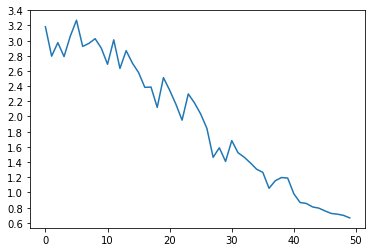

In [66]:
#hidden_size = 256
hidden_size = 100
embeddings_encoder = torch.FloatTensor(input_lang.n_words, hidden_size)
embeddings_decoder = torch.FloatTensor(input_lang.n_words, hidden_size)

encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 5000, print_every=500)
print(embeddings_encoder)
print("******----******")
print(embeddings_decoder)

In [67]:
evaluateRandomly(encoder1, attn_decoder1)

> salutations
= cordialement
< cordialement <EOS>

> cours python ?
= oui il y a des tps de python
< oui il y a des tps de python <EOS>

> combien places ?
= il y a 20 places en tout
< il y a 20 places en tout <EOS>

> ai questions
= oui posez vos questions
< je suis la pour vous aider <EOS>

> quelles unites enseignement ?
= il faut regarder sur notre site web
< il faut regarder sur notre site web <EOS>

> n ai pas fait mon m1 lyon 1 ?
= 5 places pour ceux qui ont un m1 francais
< 5 places pour ceux qui ont un m1 francais <EOS>

> voudrais inscrire .
= 
<  <EOS>

> quoi master consiste ?
= 6 mois de cours et 5 mois de stage
< au metier de data scientist <EOS>

> quels prerequis ?
= mathematiques et statistiques
< mathematiques et statistiques <EOS>

> pourriez renseigner
= oui volontiers quel est votre profil ?
< je suis la pour vous aider <EOS>



D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Asking new questions
=========

Ask new questions (never seen during training) using only the words that appear in your training set. 
No capital letters, nor numbers.

In [68]:
#newpair='bonjour monsieur'
newpair='quels sont les cours dispenses dans ce master ?'
#newpair='et les prerequis ?'
#newpair="la rentree en 2018 c est quand ?"
newpair="c est un master en un an ?"
newpair="quels sont les enseignants du master ?"
#newpair='merci monsieur'
newpair= TrimWordsTest(newpair)
output_words, attentions = evaluate(encoder1, attn_decoder1, newpair)
output_sentence = ' '.join(output_words)
print(newpair), print('->', output_sentence)

quels enseignants master ?
-> des chercheurs du liris <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(None, None)

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, I can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


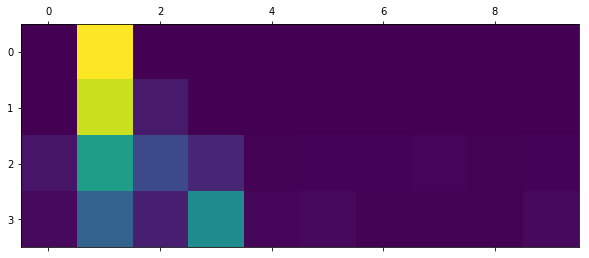

In [69]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, TrimWordsTest("quels sont les debouches ?"))
plt.matshow(attentions.numpy())

For a better viewing experience I will do the extra work of adding axes
and labels:




D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input = quelle date rentree 2018 ?
output = le rentree est le 5 septembre <EOS>


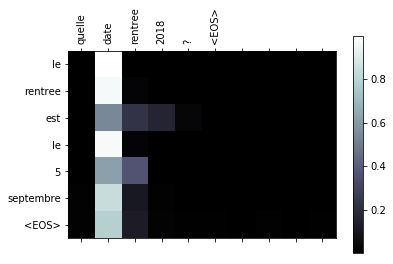

input = m2 prepare quel metier ?
output = au metier de data scientist <EOS>


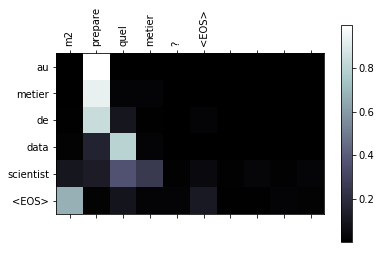

In [70]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(TrimWordsTest("a quelle date est la rentree 2018 ?"))
evaluateAndShowAttention(TrimWordsTest("ce m2 prepare a quel metier ?"))

Future work
=========

-  Discuss the weaknesses of this simple approach
-  Allow words in the new questions that are unseen during training.
-  Allow questions of > 10 words (for instance, by selecting 10 words at random in the sentence).
-  Adapt the code to handle several sequences at once (like an email)
-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe.
-  Try with more layers, more/less hidden units, and more sentences. Compare
   the training time and performance.
-  Define and plot other loss functions for this specific task (e.g. % correct words)
-  If pairs have two of the same phrase (``Bonjour \t Bonjour``), you can 
   use this as an autoencoder. Try this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for answering the questions from there




### Discuss the weaknesses of this simple approach ?


The Weaknesses of this approach can be inferred from the next questions:
* The fact that length of questions is limited
* The unpredictible behaviour of this model if I allow some unseen words during training
* The max length theory to handle & train the attention layer

### Allow words in the new questions that are unseen during training ?
I need to prepare a Data which contains an unseen word using variableFromSentence(lang, sentence) function

In [71]:
sentence_unseen='quels sont les enseignants du master au début de l\'année ?'
try:
    variable_unseen=variableFromSentence(input_lang,sentence_unseen)
except KeyError as e:
    print('{} not in the vocabulary'.format(e))

'sont' not in the vocabulary


we are sure that the word "sont" doesn't figure in our training input.
First solution, I just remove all the unseen words and go on with this model. I need to override the method indexesFromSentence to draw attention and with the remaining words, I plot the attention and see if the answer is ok.

[2, 181, 13, 4]
['quels', 'enseignants', 'master', '?']
input = quels enseignants master début l'année ?
output = des chercheurs du liris . <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


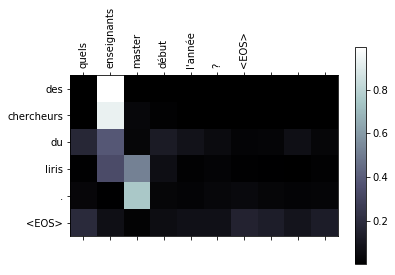

In [72]:
def indexesFromSentence(lang, sentence):
    indexes=[]
    for word in sentence.split(' '):
        try:
            indexes.append(lang.word2index[word] )
        except KeyError:
                pass
    return indexes
indexes = indexesFromSentence(input_lang, sentence_unseen)
print(indexes)
sentence_after_elimination = []
for i in indexes:
    sentence_after_elimination.append(input_lang.index2word[i])
print(sentence_after_elimination)
evaluateAndShowAttention(TrimWordsTest(sentence_unseen))

We see that the chatBot gave a false answer. So we need to improve our model by __Replacing the embeddings with pre-trained word embeddings such as word2vec.__

### Replacing the embeddings with pre-trained word embeddings such as word2vec ?

(214, 500)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 45s (- 6m 46s) (500 10%) 3.1790
1m 42s (- 6m 51s) (1000 20%) 2.7815
2m 38s (- 6m 9s) (1500 30%) 2.2149
3m 32s (- 5m 18s) (2000 40%) 1.7062
4m 30s (- 4m 30s) (2500 50%) 1.2053
5m 27s (- 3m 38s) (3000 60%) 0.7998
6m 27s (- 2m 45s) (3500 70%) 0.6539
7m 23s (- 1m 50s) (4000 80%) 0.5029
8m 24s (- 0m 56s) (4500 90%) 0.3639
9m 20s (- 0m 0s) (5000 100%) 0.2907


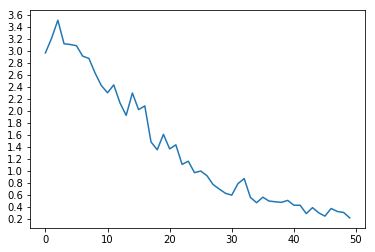

In [73]:
#import torchwordemb
#vocab, vec = torchwordemb.load_word2vec_bin("data/glove.6B.50d.txt")
#print(vec.size())
#print(vec[ w2v.vocab["apple"] ] )
#from io import open
#file = "data/glove.6B.50d.txt"
import  gensim
#word_vectors = gensim.models.KeyedVectors.load_word2vec_format('frWiki_no_phrase_no_postag_1000_skip_cut200.bin', binary=True)
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('frWac_no_postag_phrase_500_cbow_cut100.bin', binary=True)
#print(word_vectors.syn0)
#print(word_vectors.get_vector('élève'))
# assemble the embedding_weights in one numpy array
vocab_dim = 500 # dimensionality of your word vectors
n_symbols = input_lang.n_words + 1 # adding 1 to account for 0th index (for masking)
embedding_weights = np.zeros((n_symbols, vocab_dim))
for word,index in input_lang.word2index.items():
    try:
        embedding_weights[index, :] = word_vectors.get_vector(word)
    except KeyError:
        pass
hidden_size = vocab_dim
#embedding_weights = embedding_weights[0:input_lang.n_words, 0:n_symbols]
def get_embedding_weights():
    return embedding_weights
print(embedding_weights.shape)
class EncoderRNN_with_trained_embedding(nn.Module):
    def __init__(self, input_size, n_symbols, pretrained_embed, n_layers=1):
        super(EncoderRNN_with_trained_embedding, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        pretrained_embed = torch.Tensor(pretrained_embed)
        self.embedding.weight = nn.Parameter(pretrained_embed)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

class AttnDecoderRNN_with_trained_embedding(nn.Module):
    def __init__(self, hidden_size, output_size, pretrained_embed, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_with_trained_embedding, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        pretrained_embed = torch.Tensor(pretrained_embed)
        self.embedding.weight = nn.Parameter(pretrained_embed)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

encoder1 = EncoderRNN_with_trained_embedding(input_lang.n_words, hidden_size, embedding_weights)
attn_decoder1 = AttnDecoderRNN_with_trained_embedding(hidden_size, output_lang.n_words, embedding_weights,
                               1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

    #output_dim=vocab_dim, input_dim=n_symbols
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(encoder1, attn_decoder1, 5000, print_every=500)

[2, 181, 13, 4]
input = c'est quoi durée master ?
output = 6 mois de cours et 5 mois de stage <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


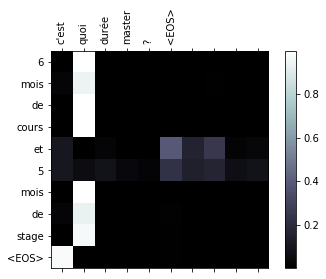

In [74]:
indexes = indexesFromSentence(input_lang, sentence_unseen)
print(indexes)
sentence_after_elimination = []
for i in indexes:
    sentence_after_elimination.append(input_lang.index2word[i])
#print(sentence_after_elimination)
#str1 = ' '.join(sentence_after_elimination)
evaluateAndShowAttention(TrimWordsTest("c'est quoi la durée de master ?"))
#print(word_vectors.get_vector("enseignant"))

[2, 181, 13, 4]
input = combien places disponibles ?
output = il y a 20 places en tout <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


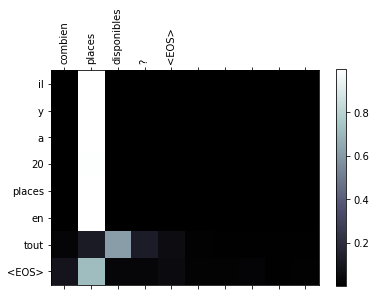

In [75]:
indexes = indexesFromSentence(input_lang, sentence_unseen)
print(indexes)
evaluateAndShowAttention(TrimWordsTest("combien de places sont disponibles ?"))

__We have a good behaviour of the chatbot. But, it's still not complete. I believe that getting a larger corpus could improve this chatBot.__
__To have this result, I made a lot of reflexions and tried many methods:__
* I tried many pretrained Embeddings word2vec downloaded from http://fauconnier.github.io/#about in order the have the lowest possible loss. I succeeded in having a loss of 0.3 which is better than the start loss.
* I tried to extract the embeddings of the original model (without pretrained embeddings) so that I can append the Embeddings of the words that exist in the corpus but not in the downloaded pretrained Embeddings. But, that was in vain because I didn't find the right method to do it.
* What I did is get the pretrained Embeddings, feed it to the encoder's embedding Layer as well as the decoder's embedding layer and then evaluate the result.
* Even if the answers are acceptable, the attention doesn't seem coherent. Which means that the chatbot needs a larger corpus to train itself.

### Allow questions of > 10 words (for instance, by selecting 10 words at random in the sentence) ?

In [76]:
import random
Long_question = "comment evolue le rythme des études notamment en statistiques et informatiques et en projets ?"
Long_question = TrimWordsTest(Long_question)
print(Long_question)
def get_10_rand_words(Long_question):
    Long_question_10_words = ""
    words = Long_question.split()
    random_words=[]
    random_word = random.choice(words)
    while random_word == "?":
        random_word = random.choice(words)
    Long_question_10_words += random_word
    Long_question_10_words += " "
    random_words.append(random_word)
    for i in range(0,8):
        random_word = random.choice(words)
        while (random_word in random_words or random_word == "?"):
            random_word = random.choice(words)
        random_words.append(random_word)
        Long_question_10_words+=random_word
        if i < 8:
            Long_question_10_words += " "
    Long_question_10_words += "?"
    return Long_question_10_words
print(get_10_rand_words(Long_question))

comment evolue rythme études notamment statistiques et informatiques et projets ?
informatiques evolue et notamment projets statistiques rythme comment études ?


input = et projets rythme evolue notamment informatiques études comment statistiques ?
output = il faut contacter la scolarite <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


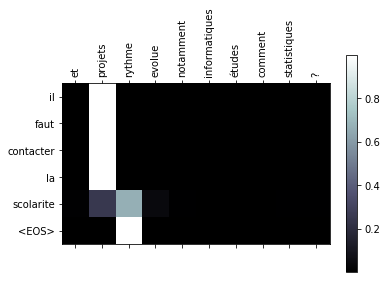

In [77]:
evaluateAndShowAttention(TrimWordsTest(get_10_rand_words(Long_question)))

__With the function above, we can have a question with random 10 words at a random order. By looking at the attention, we can't hope for a good answer because the corpus doesn't contain half or more of these words.__

__In order to improve the beahaviour of the chatBot, I thought it may be a good idea to allow unseen words with a different stratgie:__
* For instance, why not get the most close word to the unseen word in the corpus from the pre-trained embeddings.

In [78]:
#print(word_vectors.index2entity[0])
def check_if_word_in_corpus(lang, word):
    for i in range(0, lang.n_words):
        if(lang.index2word[i] == word):
            return i
    return -1
        
def get_most_close_word_from_preTrained(lang, word):
    most_similar = word_vectors.index2entity[1]
    try:
        d = word_vectors.similarity(word_vectors.index2entity[1], word)
    except:
        pass
    for w in word_vectors.index2entity:
        try:
            d1 = word_vectors.similarity(w, word)
            if(d1 >= d and check_if_word_in_corpus(lang, w) != -1):
                d = d1
                most_similar = w
                #print('a={:f}, b={:d}, c={:s}'.format(d, check_if_word_in_corpus(lang, word), w))
        except KeyError:
            pass
            
    if most_similar == word_vectors.index2entity[1]:# if no word is is found
        return -1
        #if(check_if_word_in_corpus(lang, most_similar) == -1 and most_similar in word_vectors.index2entity):
        #    lang.addWord(most_similar)
        #    embedding_weights = get_embedding_weights()
        #    #embedding_weights = embedding_weights.numpy()
        #    np.vstack((embedding_weights, word_vectors.get_vector(most_similar)))
        #    #embedding_weights.append(word_vectors.get_vector(most_similar))
        #    encoder1 = EncoderRNN_with_trained_embedding(input_lang.n_words, hidden_size, embedding_weights)
        #    attn_decoder1 = AttnDecoderRNN_with_trained_embedding(hidden_size, output_lang.n_words, embedding_weights,
        #                          1, dropout_p=0.1)
        #    trainIters(encoder1, attn_decoder1, 5000, print_every=500)
    return most_similar
        
def indexesFromSentence(lang, sentence):
    indexes=[]
    for word in sentence.split(' '):
        try:
            indexes.append(lang.word2index[word])
        except KeyError:
            if get_most_close_word_from_preTrained(lang, word) != -1:
                print(get_most_close_word_from_preTrained(lang, word))
                indexes.append(lang.word2index[get_most_close_word_from_preTrained(lang, word)])
            else:
                pass
    return indexes

__In the cell above, Note that I commented the block of code under the if statement (if most_similar == word_vectors.index2entity[1]: ). This code should be excecuted if the word isn't in the corpus but it exists in the file containing the pretrained Embeddings: I append the Embedding in the Embdding matrix, then I instantiate another encoder and decoder and then train the model so that it trains itself with the new Embedding. Actually, I tried this code and it works well, but I commented it so that I can test the model without the need to train the model everytime.
Instead, I just return -1 if I don't find a similar word that exists in the corpus and in the Embedding File at the same time.
With this strategie, the model works so Well... Tests in the Cell below are satisfying__

ne
professionnel
formation
encore
ai
Variable containing:
  188
   28
   77
  148
    6
   50
    4
    1
[torch.LongTensor of size 8x1]

formation
faire


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input = projet pas dans rendre à ou faire ?
output = non mais il faut travailler assidument <EOS>


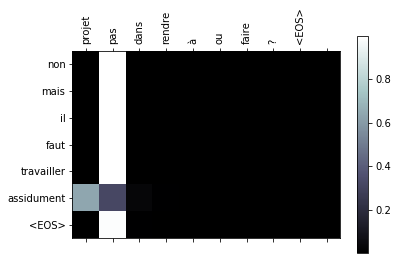

duree
input = c'est quoi durée master ?
output = le cinq septembre <EOS>


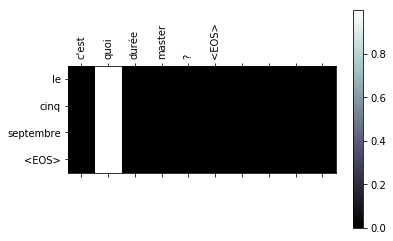

places
input = combien places disponibles ?
output = il y a 20 places en tout <EOS>


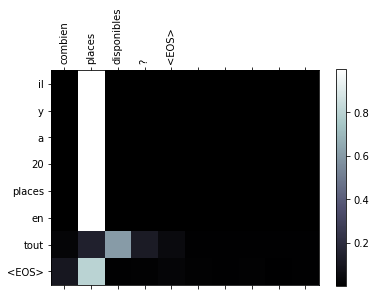

In [79]:
#print(embedding_weights)

#print(word_vectors.index2entity[0])
Long_question = "que faire si on arrive pas à avancer dans un projet ou travail à rendre ?"
print(variableFromSentence(input_lang, TrimWordsTest(get_10_rand_words(Long_question))))
evaluateAndShowAttention(TrimWordsTest(get_10_rand_words(Long_question)))
evaluateAndShowAttention(TrimWordsTest("c'est quoi la durée de master ?"))
evaluateAndShowAttention(TrimWordsTest("combien de places sont disponibles ?"))
#print(input_lang.word2index.items())
#print(input_lang.word2index['statisque'])

### Try with more/less hidden units, and more sentences. Compare the training time and performance ?

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 48s (- 7m 20s) (500 10%) 3.1305
1m 41s (- 6m 45s) (1000 20%) 2.8872
2m 34s (- 6m 0s) (1500 30%) 2.2489
3m 31s (- 5m 17s) (2000 40%) 1.6424
4m 26s (- 4m 26s) (2500 50%) 1.2100
5m 20s (- 3m 33s) (3000 60%) 0.8501
6m 21s (- 2m 43s) (3500 70%) 0.7522
7m 19s (- 1m 49s) (4000 80%) 0.5751
8m 15s (- 0m 55s) (4500 90%) 0.3675
9m 9s (- 0m 0s) (5000 100%) 0.2677


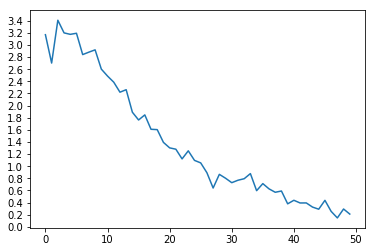

In [80]:
hidden_size_2 = 500
encoder2 = EncoderRNN_with_trained_embedding(input_lang.n_words, hidden_size_2, embedding_weights)
attn_decoder2 = AttnDecoderRNN_with_trained_embedding(hidden_size_2, output_lang.n_words, embedding_weights,
                               1, dropout_p=0.1)
if use_cuda:
    encoder2 = encoder2.cuda()
    attn_decoder2 = attn_decoder2.cuda()
trainIters(encoder2, attn_decoder2, 5000, print_every=500)

ne
professionnel
faire
ai
Variable containing:
    6
  188
   28
   51
   48
   50
    4
    1
[torch.LongTensor of size 8x1]

formation
professionnel
faire
input = à projet dans ou travail rendre faire ?
output = oui d ou venez vous ? <EOS>


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


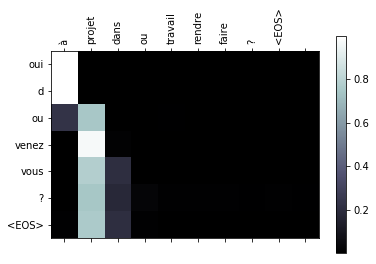

duree
input = c'est quoi durée master ?
output = 6 mois de cours et 5 mois <EOS>


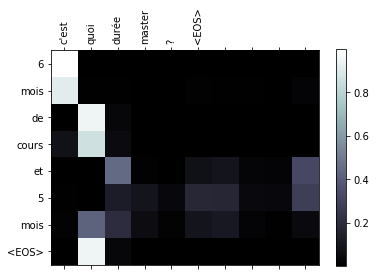

places
input = combien places disponibles ?
output = il y a 20 places en tout <EOS>


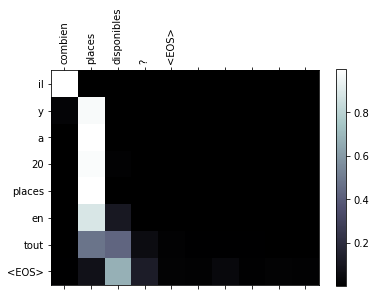

In [81]:
Long_question = "que faire si on arrive pas à avancer dans un projet ou travail à rendre ?"
print(variableFromSentence(input_lang, TrimWordsTest(get_10_rand_words(Long_question))))
def evaluateAndShowAttention_2(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
evaluateAndShowAttention_2(TrimWordsTest(get_10_rand_words(Long_question)))
evaluateAndShowAttention_2(TrimWordsTest("c'est quoi la durée de master ?"))
evaluateAndShowAttention_2(TrimWordsTest("combien de places sont disponibles ?"))

__We see that the training time has increased which is predictable considering the hidden size. Plus, the loss is now a little bit less then 0.2 which is an improvement.__

__To conclude, I managed to have a good behaviour of the ChatBot but it still needs improvement.__